## Tutorial Acuan
- https://utomorezadwi.medium.com/mendesain-pid-controller-from-scratch-menggunakan-python-1dd0aa1c806b

In [1]:
# load necessary libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy import genfromtxt as csv
from tqdm import tqdm

## Fungsi Dasar PID

In [2]:
def PID(Kp=1.0, Ti=1.0, Td=1.0, t_init=0.0, u_bar=0.0, con_type='pid'):
    """ Basic PID Controller

    args:
    - Kp : Proportional gain
    - Ti : integral period
    - Td : derivative period
    - t_init: initial time
    - u_bar: base line control signal
    - con_type: control type, either 'p', 'pi', 'pd', or 'pid'

    yield:

    u = control signal
    """

    if not(con_type=='p' or con_type=='pi' or con_type=='pd' or con_type=='pid'):
        raise ValueError("Controller Type Invalid")

    # init stored data
    e_prev = 0
    t_prev = t_init
    I = 0

    # init control
    u = u_bar

    while True:
        # yield MV, wait new t, PV, SP
        t, feedback, ref = yield u

        # PID calculations
        e = ref - feedback
        de = e - e_prev
        dt = t - t_prev

        P = Kp * e
        I = I + e*dt
        D = de/dt

        if con_type == 'p':
            u = u_bar + P
        elif con_type == 'pi':
            u = u_bar + Kp * (I/Ti)
        elif con_type == 'pd':
            u = u_bar + Kp*(e + Td*D)
        elif con_type == 'pid':
            u = u_bar + Kp*(e + (I/Ti) + Td*D)
        else:
            raise ValueError("Controller Type Invalid")

        e_prev = e
        t_prev = t

## Fungsi Transfer

Berupa fungsi step dengan sinyal MV sebagai input ke fungsi.

In [3]:
def trans_func(xin=0.0, step_up=1.0, y_mul=1.0, u_now=0.0, u_error=0.0):
    """ Step Function as Transfer Functions

    args:
    - xin : nilai input
    - step_up : nilai axis fungsi step aktif
    - y_mul : nilai multiplikasi saat fungsi aktif
    - u_now : nilai sinyal MV
    - u_error: nilai error pada sistem (opsional-arbitary)
    """

    y_res = 0.0
    if xin >= step_up:
        y_res = y_mul  + u_now/100 + u_error

    return y_res

## Data CSV hasil pengujian fisik

In [4]:
# read previous experiment data form CSV
data = csv('./percobaan_1.csv',delimiter=',')
vinp = data[:,0]
vrpm = data[:,1]
vxin = np.arange(0, np.shape(vinp)[0], 1)

## Deklarasi objek fungsi PID

In [5]:
# declare PID controller
conPID = PID(Kp=10, Ti=1, Td=1, con_type='pid')
conPID.send(None)

0.0

## Nilai SP dan input ke Fungsi Step

In [6]:
# define input for step function
set_point = 0.3
set_stepup = 9.0

## Variabel-variabel kalkulasi

In [7]:
# define PID process variabels
xarray = np.zeros(shape=250) # just for data array length
times = np.arange(start=1, stop=len(xarray), step=1) # input sesuai waktu urut
y_pref = np.zeros(shape=xarray.shape)
feedback = np.zeros(shape=xarray.shape)
u = np.zeros(shape=xarray.shape)
error = np.zeros(shape=xarray.shape)

# buffer to store previous time
t_prev = 0.0

## Nilai fungsi transfer yang diharapkan

In [8]:
# preferred value of transfer function
for t in tqdm(times):
    y_pref[t] = trans_func(xin=t, step_up=set_stepup, y_mul=set_point)

100%|████████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 108608.75it/s]


## Nilai fungsi transfer dengan PID

**Catatan:** Feedback (PV) pada nilai axis step aktif sengaja ditentukan nilai konstan untuk awalan error

In [9]:
# actual PID process
for t in tqdm(times):
    error[t] = feedback[t-1] - y_pref[t-1] # get error at time t
    u[t] = conPID.send([t, feedback[t-1], y_pref[t-1]]) # calculate PID

    if t==9:
        feedback[t] = 0.7 # error overshoot at ON
    else:
        feedback[t] = trans_func(xin=t, step_up=set_stepup, y_mul=set_point, u_now=u[t], u_error=0.4)
    t_prev = t

100%|█████████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 81205.33it/s]


## Plotting

Text(0.5, 1.0, 'Original SP vs PV')

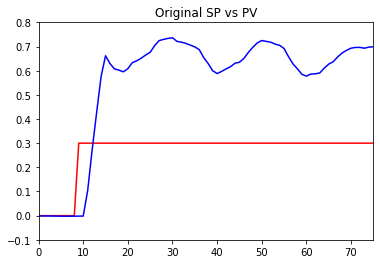

In [10]:
plt.plot(vxin, vinp, 'r', vxin, vrpm, 'b')
plt.ylim(-0.1, 0.8)
plt.xlim(0, 75)
plt.title('Original SP vs PV')

Text(0.5, 1.0, 'Simulated SP vs PV')

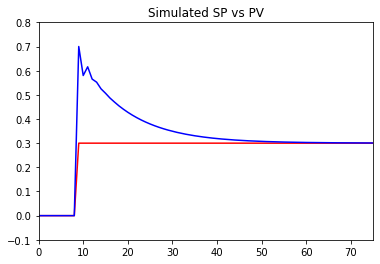

In [11]:
plt.plot([0] + times.tolist(), y_pref, 'r', [0] + times.tolist(), feedback, 'b')
plt.ylim(-0.1, 0.8)
plt.xlim(0, 75)
plt.title('Simulated SP vs PV')

Text(0.5, 1.0, 'Calculated SP vs Error')

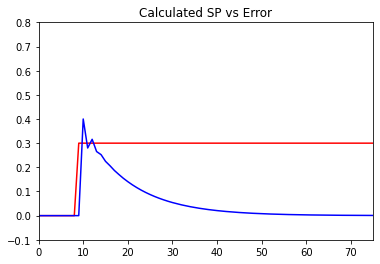

In [12]:
plt.plot([0] + times.tolist(), y_pref, 'r', [0] + times.tolist(), error, 'b')
plt.ylim(-0.1, 0.8)
plt.xlim(0,75)
plt.title('Calculated SP vs Error')

Text(0.5, 1.0, 'Calculated SP vs MV')

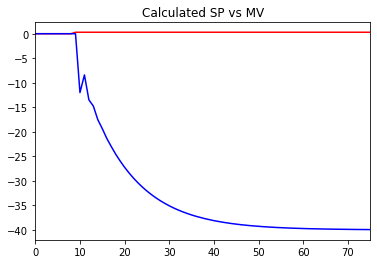

In [13]:
plt.plot([0] + times.tolist(), y_pref, 'r', [0] + times.tolist(), u, 'b')
plt.xlim(0,75)
plt.title('Calculated SP vs MV')